In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker

%matplotlib inline

import numpy as np
import pandas as pd
import glob
import shutil
from tqdm import tqdm
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

This notebook conducts the post-processing of computational time for cross-correlation to evaluate its scaling with number of cores/nodes.

# Single-node scaling

In [2]:
rootdir_singlenode = "./Scaling/scaling_singlenode"

In [3]:
# Read cpu time for warmup and main run
np_single = [1, 2, 4, 8, 16, 32]
Ntrial = 5

cputime_main_all = np.zeros((len(np_single), Ntrial))

for i, NP in enumerate(np_single):
    cputime_main_np = []
    for j in range(Ntrial):
        finame = "np{}_{}.txt".format(NP+1, j+1)
        file_in = open(os.path.join(rootdir_singlenode, finame), 'r')
        t_warmup, t_main = file_in.read().split(' ')
        cputime_main_np.append(float(t_main))

    cputime_main_all[i, :] = cputime_main_np


In [4]:
cputime_main_all

array([[2405.19189639, 2375.43663085, 2475.11783741, 2440.35114974,
        2542.37939371],
       [1327.09271562, 1200.18362505, 1383.87069049, 1177.99809145,
        1200.6011597 ],
       [ 637.54838649,  588.11093392,  603.37470307,  591.41391687,
         604.60998757],
       [ 307.37546612,  302.46903182,  320.85854303,  336.4442108 ,
         308.66111078],
       [ 165.60148568,  165.54673016,  177.5524231 ,  217.79215122,
         167.00679681],
       [  94.56274452,   91.58210397,   91.57693858,   94.04546646,
          98.69540094]])

In [5]:
cputime_single_mean = np.mean(cputime_main_all, axis=1)
cputime_single_std = np.std(cputime_main_all, axis=1)
cputime_single_std

array([57.96354766, 82.04253367, 17.50435774, 12.24243612, 20.054046  ,
        2.60922121])

In [6]:
# compute linear regression to estimate scaling exponent
regr = LinearRegression()
X = []
for i, N in enumerate(np_single):
    for j in range(Ntrial):
        X.append(np.log10(float(N)))
        
X = np.array(X).reshape(len(X), 1)
Y = np.log10(cputime_main_all.reshape(len(np_single) * Ntrial))
x_single = np.linspace(0.8, 40, 10)
regr.fit(X, Y)
y_single = 10**regr.predict(np.log10(x_single).reshape(10, 1))
k_single, A_single = regr.coef_[0], regr.intercept_
R2score_single = regr.score(X, Y)

In [7]:
R2score_single

0.9961058423064846

In [ ]:
# plot scaling of single core

fig, ax = plt.subplots(1, 1, figsize=(6,6))

ju_col = 0.25*np.ones(3)
 
ax.grid(True, which="both", ls=":", axis="both")
ax.set_zorder(2)

ax.errorbar(np_single, cputime_single_mean, yerr=cputime_single_std, fmt='s', ms=6, mec="k", color=ju_col,
            capthick=1, capsize=3, barsabove=False, zorder=4)

ax.plot(x_single, y_single, color="k", lw=0.75, zorder=4)
ax.text(30.0, 1e3, "Scaling exponent\n = {0:5.3f}".format(k_single), ha="right", fontsize=16)

# decolate
xlimit = (0.5, 50)
ylimit = (50, 5e3)
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('CPU time [s]')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# axes for xticks to plot grid independent from minor ticks
pos1 = ax.get_position()
ax_aux=fig.add_axes(pos1) 
ax_aux.set_zorder(1)
ax_aux.set_xscale('log')
ax_aux.set_yscale('log')
ax_aux.set_xticks(np_single, minor=False)
ax_aux.set_xticklabels(np_single)
ax_aux.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


ax_aux.set_xlim(xlimit)
ax_aux.set_ylim(ylimit)
ax_aux.set_xlabel('Number of cores')


In [9]:
# Plot with bar 
# barwidth = [0.4 * 2**i for i in range(6) ]
# barwidth
# fig, ax = plt.subplots(1, 1, figsize=(6,6))

# ju_col = 0.25*np.ones(3)
 
# ax.grid(True, which="both", ls=":", axis="both")
# ax.set_zorder(2)
# ax.bar(np_single, cputime_single_mean, yerr=cputime_single_std, width=barwidth, align='center', 
#        edgecolor="k", color=ju_col, ecolor='black', capsize=3, zorder=3)

# # decolate
# xlimit = (0.6, 48)
# ylimit = (80, 3e3)
# ax.set_xlim(xlimit)
# ax.set_ylim(ylimit)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylabel('CPU time [s]')
# ax.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off

# # axes for xticks to plot grid independent from minor ticks
# pos1 = ax.get_position()
# ax_aux=fig.add_axes(pos1) 
# ax_aux.set_zorder(1)
# # ax_aux.tick_params(
# #     axis='y',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom=False,      # ticks along the bottom edge are off
# #     top=False,         # ticks along the top edge are off
# #     labelbottom=False) # labels along the bottom edge are off
# ax_aux.set_xscale('log')
# ax_aux.set_yscale('log')
# ax_aux.set_xticks(np_single, minor=False)
# ax_aux.set_xticklabels(np_single)
# ax_aux.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='minor',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off


# ax_aux.set_xlim(xlimit)
# ax_aux.set_ylim(ylimit)
# ax_aux.set_xlabel('Number of cores')



# Multinode scaling

**NOTE:**

CPU time can be defined either with the internal job running time output from julia script or the total time including cpu allocation/deallocation. Both results are found in this repository (`out_ex_***` and `execout_includejobend`). Since the later includes the efficiency of cluster, which is not essential for the scaling of julia performance, we use the former to evaluate the scaling across nodes.

The number of cores are also defined with either (host + workers) or (workers). For the pure scaling, we can use the later. The single-node plot above defines in such a way. ~~For multi-node, however, we use the former for the sake of simplicity to run the simulation with np equal to cpu allocation defined in job batch script (e.g. n=36). ~~

In [10]:
rootdir_multinode = './Scaling'
totaldays = 6819 #from 2002-01-01 to 2020-09-01
# Read cpu time 
Nnodes = np.array([16, 32, 64, 128])
Ncorespernode = 36
Ncores = Nnodes * Ncorespernode

cputime_multinode_main_all = []

for Nnode in Nnodes:
    print("start process Nnode = {}".format(Nnode))
    Ndayspernode = int(np.floor(totaldays/Nnode))
    outfiles = glob.glob(os.path.join(rootdir_multinode, "ex_cc_raw_{:d}_INPUT".format(Nnode), "out_ex_*"))    

    cputime_tmp = []

    for outfile in outfiles:
    #     print(outfile)
        # Parse start and end time
        _, ststr, etstr = os.path.basename(outfile).split('.')[0].split('__')
    #     print(ststr, etstr)
        st = datetime.datetime.strptime(ststr, '%Y-%m-%dT%H-%M-%S')
        et = datetime.datetime.strptime(etstr, '%Y-%m-%dT%H-%M-%S')
        Ndays = (et - st).days # days computed in this job
#         print("days of job, average days per node",Ndays, Ndayspernode)

        if Ndays < 0.9*Ndayspernode:
            print("{} compute small number of days: {}/{}. Skipping".format(outfile, Ndays, Ndayspernode))
            continue

        # Read cpu time from output log
        # We search 'SeisXcorrelation successfully done in *** seconds.', otherwise skip as this job is not succeeded
        completeflag = False
        with open(outfile, 'r') as fi:
            for line in fi:
                if 'SeisXcorrelation successfully done' in line:
    #                 print(line)
                    #parse cpu time
                    cputime_tmp.append(float(line.split(' ')[4]))
                    completeflag = True
                    break

        if not completeflag:
            warnings.warn("{} has not completed the job.".format(outfile))

    cputime_multinode_main_all.append(cputime_tmp)

start process Nnode = 16
./Scaling/ex_cc_raw_16_INPUT/out_ex_cc_raw_16_3180361__2020-08-30T00-00-00__2020-09-01T00-00-00.txt compute small number of days: 2/426. Skipping
start process Nnode = 32
./Scaling/ex_cc_raw_32_INPUT/out_ex_cc_raw_32_3195920__2020-08-30T00-00-00__2020-09-01T00-00-00.txt compute small number of days: 2/213. Skipping
start process Nnode = 64
./Scaling/ex_cc_raw_64_INPUT/out_ex_cc_raw_64_3198597__2020-07-29T00-00-00__2020-09-01T00-00-00.txt compute small number of days: 34/106. Skipping
start process Nnode = 128
./Scaling/ex_cc_raw_128_INPUT/out_ex_cc_raw_128_3198754__2020-07-29T00-00-00__2020-09-01T00-00-00.txt compute small number of days: 34/53. Skipping


In [11]:
Ncores

array([ 576, 1152, 2304, 4608])

In [12]:
cputime_multi_mean = [ np.mean(x) for x in  cputime_multinode_main_all]
cputime_multi_std  = [ np.std(x) for x in  cputime_multinode_main_all]

In [13]:
cputime_multi_mean
cputime_multi_std

[543.8390326064361, 306.57787487135863, 168.29787345558546, 88.49832014074423]

In [14]:
# compute linear regression to estimate scaling exponent
regr = LinearRegression()
X = []
Y = []
for i, N in enumerate(Ncores):
    cputimes = cputime_multinode_main_all[i]
    for j in range(len(cputimes)):
        X.append(np.log10(float(N)))
        Y.append(np.log10(float(cputimes[j])))
        
X = np.array(X).reshape(len(X), 1)

x_multi = np.linspace(400, 7000, 10)
regr.fit(X, Y)
y_multi  = 10**regr.predict(np.log10(x_multi).reshape(10, 1))
k_multi, A_multi = regr.coef_[0], regr.intercept_
R2score_multi = regr.score(X, Y)

In [15]:
R2score_multi

0.9644976006685366

In [ ]:
# line plot

fig, ax = plt.subplots(1, 1, figsize=(6,6))

ju_col = 0.25*np.ones(3)
 
ax.grid(True, which="both", ls=":", axis="both")
ax.set_zorder(2)

ax.errorbar(Ncores, cputime_multi_mean, yerr=cputime_multi_std, fmt='s', ms=6, mec="k", color=ju_col,
            capthick=1, capsize=3, barsabove=False, zorder=6)

ax.plot(x_multi , y_multi , color="k", lw=0.75, zorder=5)
ax.text(8e3, 4e3, "Scaling exponent\n = {0:5.3f}".format(k_multi), ha="right", fontsize=16)

# # decolate
xlimit = (300, 1e4)
ylimit = (300, 1e4)
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('CPU time [s]')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# axis for number of core
pos1 = ax.get_position()
ax_aux1=fig.add_axes(pos1)
ax_aux1.set_zorder(1.5)
ax_aux1.set_xscale('log')
ax_aux1.set_yscale('log')
ax_aux1.set_xlim(xlimit)
ax_aux1.set_ylim(ylimit)
ax_aux1.set_xlabel('Number of cores')

ax_aux1.set_xticks(Ncores, minor=False)
ax_aux1.set_xticklabels(Ncores)
ax_aux1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# axis for number of modes
pos2 = ax.get_position()
pos2 = matplotlib.transforms.Bbox([[pos2._points[0, 0], pos2._points[0, 1]-0.1], [pos2._points[1, 0], 0.2]])

ax_aux2=fig.add_axes(pos2)
ax_aux2.set_zorder(1)
ax_aux2.set_xscale('log')
ax_aux2.set_yscale('log')
ax_aux2.set_xlim(xlimit)
ax_aux2.set_ylim(ylimit)
ax_aux2.set_xlabel('Number of nodes')

ax_aux2.yaxis.set_visible(False) # hide the yaxis

ax_aux2.set_xticks(Ncores, minor=False)
ax_aux2.set_xticklabels(Nnodes)
ax_aux2.tick_params(labelleft=False)
ax_aux2.spines["top"].set_visible(False)
ax_aux2.spines["bottom"].set_visible(False)
ax_aux2.spines["left"].set_visible(False)
ax_aux2.spines["right"].set_visible(False)

ax_aux2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off



# Plot for article

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,8))

#-------------------------------#
# plot scaling of single core
#-------------------------------#
ax = axs[0]

ju_col = 0.25*np.ones(3)
 
ax.grid(True, which="both", ls=":", axis="both")
ax.set_zorder(2)

ax.errorbar(np_single, cputime_single_mean, yerr=cputime_single_std, fmt='s', ms=6, mec="k", color=ju_col,
            capthick=1, capsize=3, barsabove=False, zorder=4)

ax.plot(x_single, y_single, color="k", lw=0.75, zorder=4)
ax.text(30.0, 1.8e3, "Scaling exponent\n = {0:5.3f}".format(k_single), va="top", ha="right", fontsize=16)

# decolate
xlimit = (0.5, 50)
ylimit = (50, 5e3)
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('CPU time [s]')
ax.set_title('Scaling with station-channel pairs')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.set_aspect('equal')

# axes for xticks to plot grid independent from minor ticks
pos1 = ax.get_position()
ax_aux=fig.add_axes(pos1) 
ax_aux.set_zorder(1)
ax_aux.set_xscale('log')
ax_aux.set_yscale('log')
ax_aux.set_xticks(np_single, minor=False)
ax_aux.set_xticklabels(np_single)
ax_aux.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


ax_aux.set_xlim(xlimit)
ax_aux.set_ylim(ylimit)
ax_aux.set_xlabel('Number of cores')
ax_aux.set_aspect('equal')


#-------------------------------#
# plot multi-node scaling
#-------------------------------#

ax = axs[1]
 
ax.grid(True, which="both", ls=":", axis="both")
ax.set_zorder(2)

ax.errorbar(Ncores, cputime_multi_mean, yerr=cputime_multi_std, fmt='s', ms=6, mec="k", color=ju_col,
            capthick=1, capsize=3, barsabove=False, zorder=6)

ax.plot(x_multi , y_multi , color="k", lw=0.75, zorder=5)
ax.text(8e3, 4.5e3, "Scaling exponent\n = {0:5.3f}".format(k_multi), va="top", ha="right", fontsize=16)

# # decolate
xlimit = (300, 1e4)
ylimit = (300, 1e4)
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('CPU time [s]')
ax.set_title('Scaling with time chunk')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.set_aspect('equal')

# axis for number of core
pos1 = ax.get_position()
ax_aux1=fig.add_axes(pos1)
ax_aux1.set_zorder(1.5)
ax_aux1.set_xscale('log')
ax_aux1.set_yscale('log')
ax_aux1.set_xlim(xlimit)
ax_aux1.set_ylim(ylimit)
ax_aux1.set_xlabel('Number of cores')

ax_aux1.set_xticks(Ncores, minor=False)
ax_aux1.set_xticklabels(Ncores)
ax_aux1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax_aux1.set_aspect('equal')

# axis for number of modes
pos2 = ax.get_position()
pos2 = matplotlib.transforms.Bbox([[pos2._points[0, 0], pos2._points[0, 1]-0.15], [pos2._points[1, 0], pos2._points[1, 1]]])

ax_aux2=fig.add_axes(pos2)
ax_aux2.set_zorder(1)
ax_aux2.set_xscale('log')
ax_aux2.set_yscale('log')
ax_aux2.set_xlim(xlimit)
ax_aux2.set_ylim(ylimit)
ax_aux2.set_xlabel('Number of nodes')

ax_aux2.yaxis.set_visible(False) # hide the yaxis

ax_aux2.set_xticks(Ncores, minor=False)
ax_aux2.set_xticklabels(Nnodes)
ax_aux2.tick_params(labelleft=False)
ax_aux2.spines["top"].set_visible(False)
ax_aux2.spines["bottom"].set_visible(False)
ax_aux2.spines["left"].set_visible(False)
ax_aux2.spines["right"].set_visible(False)

ax_aux2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_aux2.set_aspect('equal')

# plot figure index
plt.text(0.1, 0.9, "(a)", fontsize=20, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.5, 0.9, "(b)", fontsize=20, weight="bold", transform=plt.gcf().transFigure)

plt.savefig("./Scaling/BP_parallelization_scaling.eps", dpi=150)
plt.savefig("./Scaling/BP_parallelization_scaling.png", dpi=150, facecolor="w",bbox_inches="tight")

# Evaluate JIT Precompilation

In [18]:
# Read cpu time for warmup and main run
np_single = [1, 2, 4, 8, 16, 32]
Ntrial = 5

cputime_warmup_all = np.zeros((len(np_single), Ntrial)) # one day cc to evaluate JIT precompilation

for i, NP in enumerate(np_single):
    cputime_warmup_np = []
    for j in range(Ntrial):
        finame = "np{}_{}.txt".format(NP+1, j+1)
        file_in = open(os.path.join(rootdir_singlenode, finame), 'r')
        t_warmup, t_main = file_in.read().split(' ')
        cputime_warmup_np.append(float(t_warmup))

    cputime_warmup_all[i, :] = cputime_warmup_np


In [19]:
cputime_warmup_all

array([[572.72172452, 544.77766647, 547.48372918, 553.45800249,
        544.88945009],
       [341.72237036, 330.66425491, 304.77083958, 311.14871772,
        304.47160266],
       [194.96235552, 196.01741361, 187.50813036, 191.74314126,
        190.94622322],
       [135.32794419, 130.68840698, 131.57632351, 130.27216688,
        133.52801975],
       [108.84762374, 105.83443418, 102.9797433 , 104.02161183,
        105.85856242],
       [ 92.42818447,  91.3841974 ,  93.27551326,  91.61802712,
         95.14572114]])

In [20]:
cputime_warmup_mean = np.mean(cputime_warmup_all, axis=1)
cputime_warmup_std = np.std(cputime_warmup_all, axis=1)
cputime_warmup_std

array([10.51109718, 15.01039159,  3.0328629 ,  1.89247085,  1.99919839,
        1.36117025])

In [21]:
def f_cputime(np, A, B):
    k = -0.94 # estimated from main run above.
    return A*np**k+B #ax^k + b: a=cputime with single core. k=scaling exponents. b=JIT precompilation time 

p0 = [500, 70]
popt, pcov = curve_fit(f_cputime, np_single, cputime_warmup_mean, p0=p0, sigma=cputime_warmup_std, method='lm')

A_best, B_best = popt
print((A_best, B_best))

x_warmup_ = np.linspace(0.8, 40, 100)
y_warmup_ = np.array([f_cputime(x, A_best, B_best) for x in x_warmup_])

(455.5085823384608, 72.35997822865264)


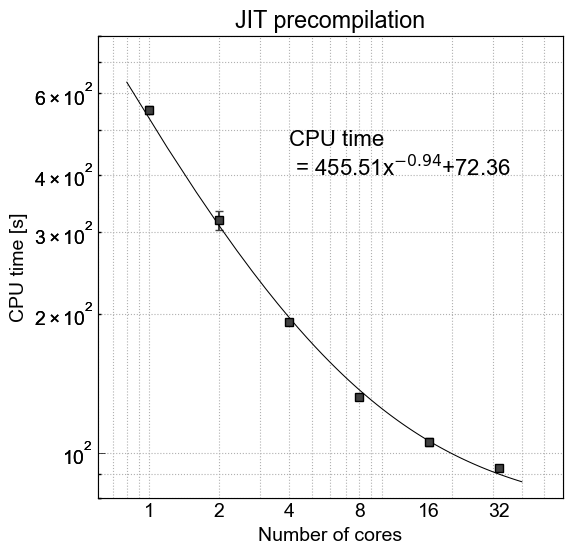

In [22]:
# plot scaling of single core
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ju_col = 0.25*np.ones(3)
 
ax.grid(True, which="both", ls=":", axis="both")
ax.set_zorder(2)

ax.errorbar(np_single, cputime_warmup_mean, yerr=cputime_warmup_std, fmt='s', ms=6, mec="k", color=ju_col,
            capthick=1, capsize=3, barsabove=False, zorder=4)

ax.plot(x_warmup_, y_warmup_, color="k", lw=0.75, zorder=4)

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

ax.text(4.0, 400, "CPU time\n = {:4.2f}x$^{{-0.94}}$+{:4.2f}".format(A_best, B_best), ha="left", fontsize=16)

# decolate
xlimit = (0.6, 60)
ylimit = (80, 800)
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('CPU time [s]')
ax.set_title('JIT precompilation')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# axes for xticks to plot grid independent from minor ticks
pos1 = ax.get_position()
ax_aux=fig.add_axes(pos1) 
ax_aux.set_zorder(1)
ax_aux.set_xscale('log')
ax_aux.set_yscale('log')
ax_aux.set_xticks(np_single, minor=False)
ax_aux.set_xticklabels(np_single)
ax_aux.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_aux.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_aux.set_xlim(xlimit)
ax_aux.set_ylim(ylimit)
ax_aux.set_xlabel('Number of cores')
plt.savefig("./Scaling/BP_parallelization_JITcompilation.png", dpi=150, facecolor="w",bbox_inches="tight")